In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-genomics/cleaned_data_no_outliers.csv


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer

In [3]:
output_dir = "/kaggle/working/"

In [4]:
# For reproducibility
np.random.seed(42)

In [5]:
# Load the dataset
Data = pd.read_csv('/kaggle/input/cleaned-genomics/cleaned_data_no_outliers.csv')

In [6]:
# First, let's examine the distribution of LN_IC50 to determine a threshold for binarization
plt.figure(figsize=(10, 6))
sns.histplot(Data['LN_IC50'], kde=True)
plt.title('Distribution of LN_IC50 Values')
plt.xlabel('LN_IC50')
plt.ylabel('Frequency')
plt.axvline(Data['LN_IC50'].median(), color='red', linestyle='--', label=f'Median: {Data["LN_IC50"].median():.2f}')
plt.legend()
plt.savefig('/kaggle/working/ln_ic50_distribution.png')
plt.close()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [7]:
# Convert LN_IC50 to binary categories
# Lower values indicate higher drug sensitivity
# Using the median as a threshold to create balanced classes
threshold = Data['LN_IC50'].median()
Data['Drug_Sensitivity'] = (Data['LN_IC50'] <= threshold).astype(int)
print(f"Threshold used for binarization: {threshold:.4f}")
print(f"Class distribution: {Data['Drug_Sensitivity'].value_counts(normalize=True).round(3) * 100}% for each class")

Threshold used for binarization: 3.5575
Class distribution: Drug_Sensitivity
1    50.0
0    50.0
Name: proportion, dtype: float64% for each class


In [8]:
# Visualize the binary classification
plt.figure(figsize=(8, 6))
sns.countplot(x='Drug_Sensitivity', data=Data)
plt.title('Distribution of Binary Drug Sensitivity Classes')
plt.xlabel('Drug Sensitivity (1=Sensitive, 0=Resistant)')
plt.ylabel('Count')
plt.savefig('/kaggle/working/binary_class_distribution.png')
plt.close()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'lymphoma'),
  Text(1, 0, 'leukemia'),
  Text(2, 0, 'myeloma'),
  Text(3, 0, 'neuroblastoma'),
  Text(4, 0, 'bone'),
  Text(5, 0, 'lung_SCLC'),
  Text(6, 0, 'aero_dig_tract'),
  Text(7, 0, 'soft_tissue'),
  Text(8, 0, 'skin'),
  Text(9, 0, 'kidney')])

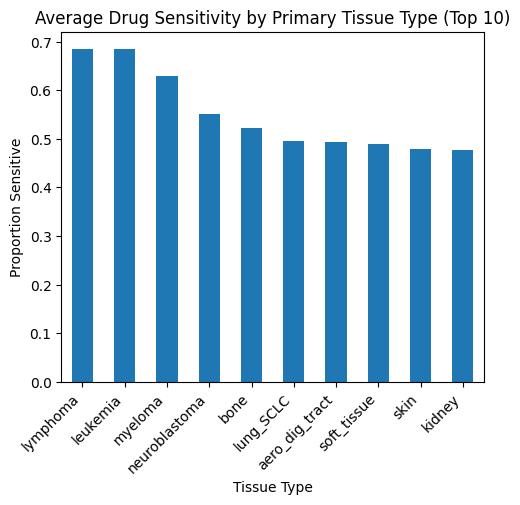

In [9]:
# Explore the relationship between target variable and some key features
plt.figure(figsize=(12, 10))

# Look at drug sensitivity by tissue type
plt.subplot(2, 2, 1)
sensitivity_by_tissue = Data.groupby('GDSC Tissue descriptor 1')['Drug_Sensitivity'].mean().sort_values(ascending=False).head(10)
sensitivity_by_tissue.plot(kind='bar')
plt.title('Average Drug Sensitivity by Primary Tissue Type (Top 10)')
plt.xlabel('Tissue Type')
plt.ylabel('Proportion Sensitive')
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Mitosis'),
  Text(1, 0, 'EGFR signaling'),
  Text(2, 0, 'Cell cycle'),
  Text(3, 0, 'RTK signaling'),
  Text(4, 0, 'Apoptosis regulation'),
  Text(5, 0, 'Cytoskeleton'),
  Text(6, 0, 'PI3K/MTOR signaling'),
  Text(7, 0, 'Unclassified'),
  Text(8, 0, 'IGF1R signaling'),
  Text(9, 0, 'ERK MAPK signaling')])

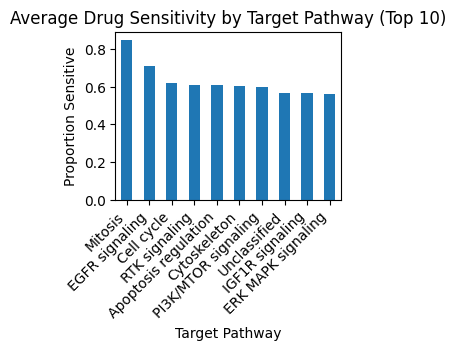

In [10]:
# Look at drug sensitivity by drug target pathway
plt.subplot(2, 2, 2)
sensitivity_by_pathway = Data.groupby('TARGET_PATHWAY')['Drug_Sensitivity'].mean().sort_values(ascending=False).head(10)
sensitivity_by_pathway.plot(kind='bar')
plt.title('Average Drug Sensitivity by Target Pathway (Top 10)')
plt.xlabel('Target Pathway')
plt.ylabel('Proportion Sensitive')
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Dactolisib'),
  Text(1, 0, 'Podophyllotoxin bromide'),
  Text(2, 0, 'Sabutoclax'),
  Text(3, 0, 'Vinorelbine'),
  Text(4, 0, 'SN-38'),
  Text(5, 0, 'Obatoclax Mesylate'),
  Text(6, 0, 'GSK626616AC'),
  Text(7, 0, 'Vinblastine'),
  Text(8, 0, 'Staurosporine'),
  Text(9, 0, 'Romidepsin')])

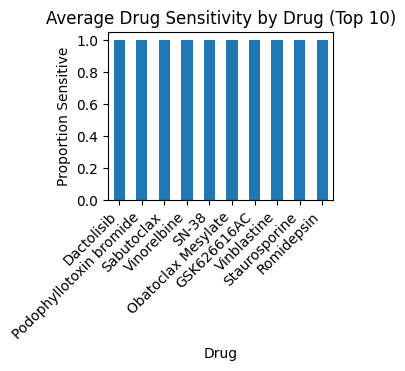

In [11]:
# Look at drug sensitivity by drug
plt.subplot(2, 2, 3)
sensitivity_by_drug = Data.groupby('DRUG_NAME')['Drug_Sensitivity'].mean().sort_values(ascending=False).head(10)
sensitivity_by_drug.plot(kind='bar')
plt.title('Average Drug Sensitivity by Drug (Top 10)')
plt.xlabel('Drug')
plt.ylabel('Proportion Sensitive')
plt.xticks(rotation=45, ha='right')

In [12]:
# Look at drug sensitivity by MSI status
plt.subplot(2, 2, 4)
sensitivity_by_msi = Data.groupby('Microsatellite instability Status (MSI)')['Drug_Sensitivity'].mean().sort_values(ascending=False)
sensitivity_by_msi.plot(kind='bar')
plt.title('Average Drug Sensitivity by MSI Status')
plt.xlabel('MSI Status')
plt.ylabel('Proportion Sensitive')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/kaggle/working/feature_relationships.png')
plt.close()

In [13]:
# Prepare features for modeling
# Define categorical and numerical features
categorical_features = [
    'CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_NAME', 'GDSC Tissue descriptor 1', 
    'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)', 
    'Microsatellite instability Status (MSI)', 'Screen Medium', 'Growth Properties',
    'TARGET', 'TARGET_PATHWAY'
]

numerical_features = ['AUC', 'Z_SCORE', 'CNA', 'Gene Expression', 'Methylation']

In [14]:
# For simplicity and performance, we'll use a subset of the features
# In a real analysis, we might try different feature combinations
selected_categorical = ['GDSC Tissue descriptor 1', 'TARGET_PATHWAY', 'Growth Properties', 
                        'Microsatellite instability Status (MSI)']
selected_numerical = ['AUC', 'Z_SCORE', 'CNA', 'Gene Expression', 'Methylation']

# Handle potential null values in categorical features
for feature in selected_categorical:
    if Data[feature].isnull().any():
        most_common = Data[feature].mode()[0]
        Data[feature] = Data[feature].fillna(most_common)

# Define target and features
X = Data[selected_numerical + selected_categorical]
y = Data['Drug_Sensitivity']

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Save the raw train and test dataframes before preprocessing
X_train.to_csv('/kaggle/working/X_train_LR.csv', index=False)
X_test.to_csv('/kaggle/working/X_test_LR.csv', index=False)
y_train.to_csv('/kaggle/working/y_train_LR.csv', index=False)
y_test.to_csv('/kaggle/working/y_test_LR.csv', index=False)

# Set up feature transformation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), selected_categorical)
    ])

In [16]:
X_train.head().T

,79336,44677,44307,132658,2230
AUC,0.938338,0.965572,0.969559,0.950325,0.925951
Z_SCORE,-1.852184,0.976475,0.413687,-0.826462,0.819702
CNA,1,1,1,1,1
Gene Expression,1,1,1,1,1
Methylation,1,1,1,1,1
GDSC Tissue descriptor 1,lymphoma,nervous_system,aero_dig_tract,breast,nervous_system
TARGET_PATHWAY,Chromatin other,DNA replication,DNA replication,Unclassified,Mitosis
Growth Properties,Suspension,Adherent,Adherent,Adherent,Adherent
Microsatellite instability Status (MSI),MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L


In [17]:
X_test.head().T

,58845,147858,98292,108246,88335
AUC,0.843458,0.912592,0.951393,0.985895,0.970862
Z_SCORE,-0.431001,0.212285,2.520482,0.986896,-0.065421
CNA,1,1,1,1,1
Gene Expression,1,1,1,1,1
Methylation,1,1,1,1,1
GDSC Tissue descriptor 1,nervous_system,kidney,Unknown,aero_dig_tract,leukemia
TARGET_PATHWAY,Genome integrity,PI3K/MTOR signaling,"Other, kinases",ERK MAPK signaling,PI3K/MTOR signaling
Growth Properties,Adherent,Adherent,Adherent,Adherent,Suspension
Microsatellite instability Status (MSI),MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSI-H


In [18]:
y_train

79336     1
44677     0
44307     0
132658    1
2230      1
         ..
119879    1
103694    0
131932    1
146867    0
121958    0
Name: Drug_Sensitivity, Length: 148756, dtype: int64

In [19]:
# Preprocess the training set
X_train_processed = preprocessor.fit_transform(X_train)

# Preprocess the test set
X_test_processed = preprocessor.transform(X_test)

# Get feature names for transformed data
num_feature_names = selected_numerical
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(selected_categorical)
feature_names = list(num_feature_names) + list(cat_feature_names)

# Convert to dataframes
X_train_processed_df = pd.DataFrame(
    X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed, 
    columns=feature_names
)
X_test_processed_df = pd.DataFrame(
    X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed, 
    columns=feature_names
)

# Save the processed dataframes
X_train_processed_df.to_csv('/kaggle/working/X_train_processed_LR.csv', index=False)
X_test_processed_df.to_csv('/kaggle/working/X_test_processed_LR.csv', index=False)

In [20]:
X_train_processed_df.head().T

,0,1,2,3,4
AUC,0.189464,0.576490,0.633149,0.359813,0.013431
Z_SCORE,-2.208767,0.971349,0.338635,-1.055600,0.795097
CNA,0.000000,0.000000,0.000000,0.000000,0.000000
Gene Expression,0.000000,0.000000,0.000000,0.000000,0.000000
Methylation,0.000000,0.000000,0.000000,0.000000,0.000000
GDSC Tissue descriptor 1_Unknown,0.000000,0.000000,0.000000,0.000000,0.000000
GDSC Tissue descriptor 1_aero_dig_tract,0.000000,0.000000,1.000000,0.000000,0.000000
GDSC Tissue descriptor 1_bone,0.000000,0.000000,0.000000,0.000000,0.000000
GDSC Tissue descriptor 1_breast,0.000000,0.000000,0.000000,1.000000,0.000000
GDSC Tissue descriptor 1_digestive_system,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
X_test_processed_df.head().T

,0,1,2,3,4
AUC,-1.158887,-0.176415,0.374990,0.865302,0.651666
Z_SCORE,-0.611004,0.112209,2.707196,0.983065,-0.200001
CNA,0.000000,0.000000,0.000000,0.000000,0.000000
Gene Expression,0.000000,0.000000,0.000000,0.000000,0.000000
Methylation,0.000000,0.000000,0.000000,0.000000,0.000000
GDSC Tissue descriptor 1_Unknown,0.000000,0.000000,1.000000,0.000000,0.000000
GDSC Tissue descriptor 1_aero_dig_tract,0.000000,0.000000,0.000000,1.000000,0.000000
GDSC Tissue descriptor 1_bone,0.000000,0.000000,0.000000,0.000000,0.000000
GDSC Tissue descriptor 1_breast,0.000000,0.000000,0.000000,0.000000,0.000000
GDSC Tissue descriptor 1_digestive_system,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
# Set up the modeling pipeline
model = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear')

# Train the model
model.fit(X_train_processed, y_train)

# Make predictions
y_pred = model.predict(X_test_processed)
y_pred_prob = model.predict_proba(X_test_processed)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

In [23]:
# Display results
print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Model Accuracy: 0.8303

Confusion Matrix:
[[21428  3300]
 [ 5114 19744]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     24728
           1       0.86      0.79      0.82     24858

    accuracy                           0.83     49586
   macro avg       0.83      0.83      0.83     49586
weighted avg       0.83      0.83      0.83     49586



In [24]:
# Save results to files
with open('/kaggle/working/model_results.txt', 'w') as f:
    f.write(f"Model Accuracy: {accuracy:.4f}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(conf_matrix) + "\n\n")
    f.write("Classification Report:\n")
    f.write(class_report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Resistant', 'Sensitive'],
            yticklabels=['Resistant', 'Sensitive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/kaggle/working/confusion_matrix_LR.png')
plt.close()

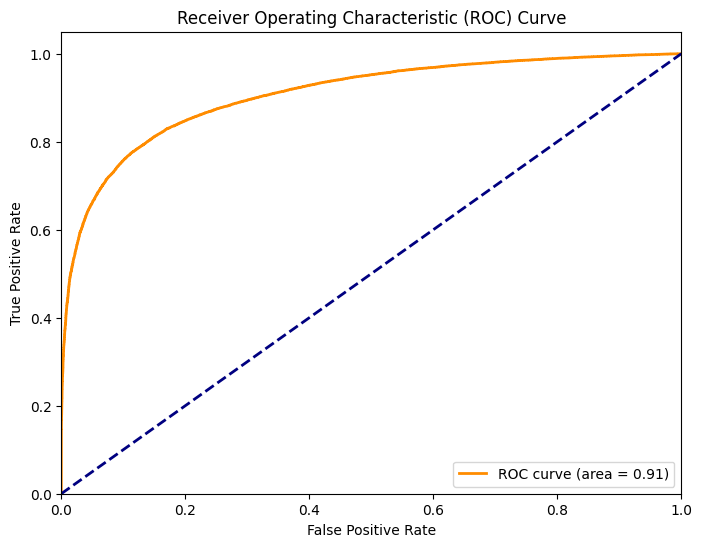

In [25]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/roc_curve_LR.png')
plt.show()

In [26]:
# Analyze feature importance for numerical features
# Extract coefficients and feature names
coefficients = model.coef_[0]

# Create dataframe for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Importance': np.abs(coefficients)
})

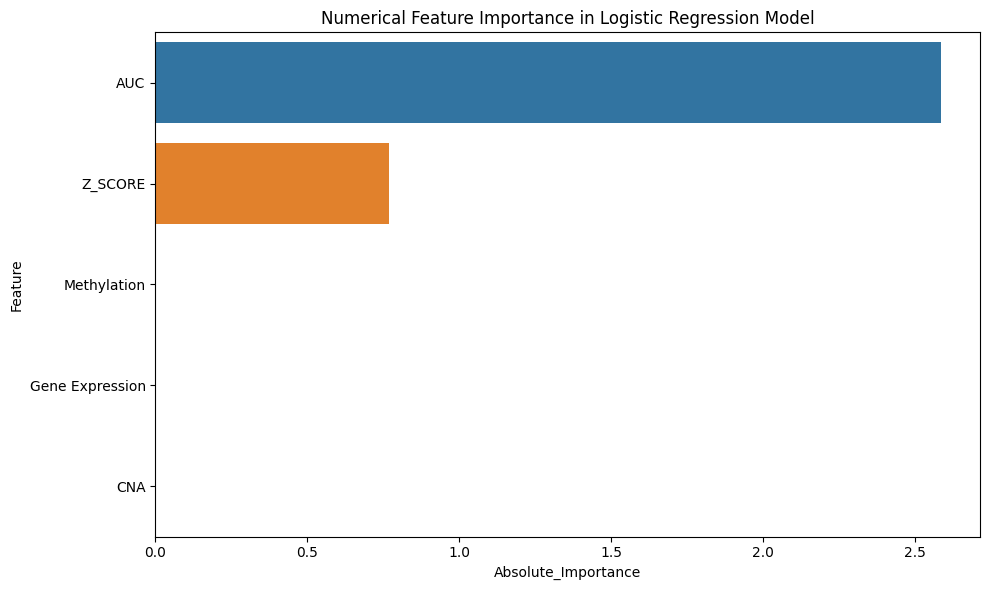

In [27]:
# Sort by absolute importance
feature_importance = feature_importance.sort_values('Absolute_Importance', ascending=False)

# Save feature importance to CSV
feature_importance.to_csv('/kaggle/working/feature_importance.csv', index=False)

# Plot numerical feature importance
plt.figure(figsize=(10, 6))
numerical_importance = feature_importance[feature_importance['Feature'].isin(selected_numerical)]
sns.barplot(x='Absolute_Importance', y='Feature', data=numerical_importance)
plt.title('Numerical Feature Importance in Logistic Regression Model')
plt.tight_layout()
plt.savefig('/kaggle/working/numerical_feature_importance.png')
plt.show()

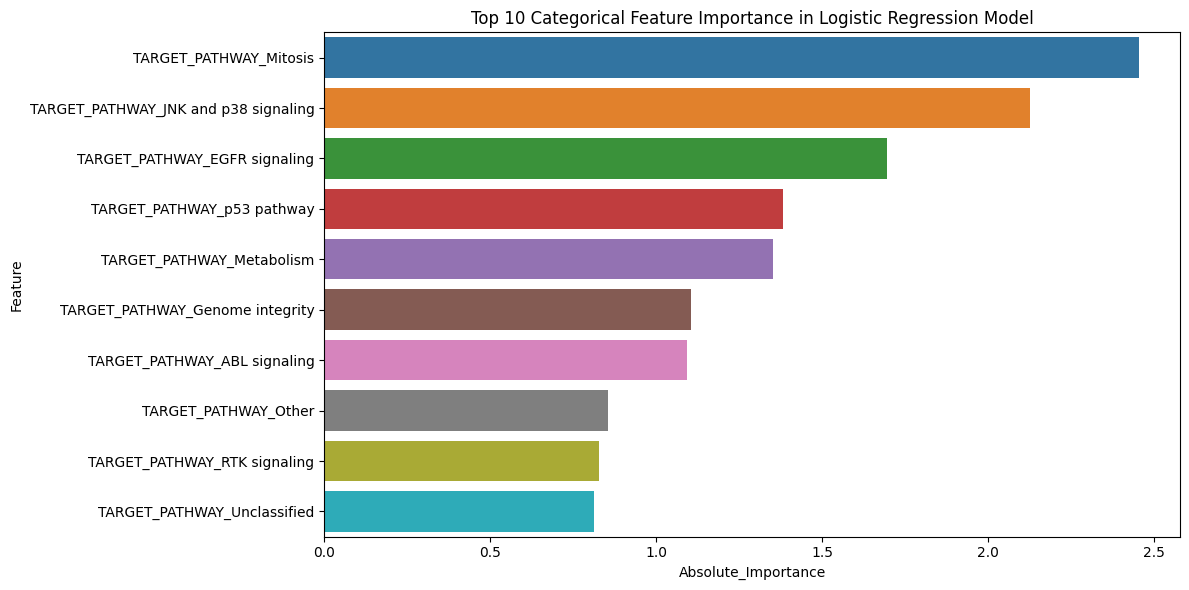

In [28]:
# Plot top 10 categorical feature importance
plt.figure(figsize=(12, 6))
categorical_importance = feature_importance[~feature_importance['Feature'].isin(selected_numerical)].head(10)
sns.barplot(x='Absolute_Importance', y='Feature', data=categorical_importance)
plt.title('Top 10 Categorical Feature Importance in Logistic Regression Model')
plt.tight_layout()
plt.savefig('/kaggle/working/categorical_feature_importance.png')
plt.show()

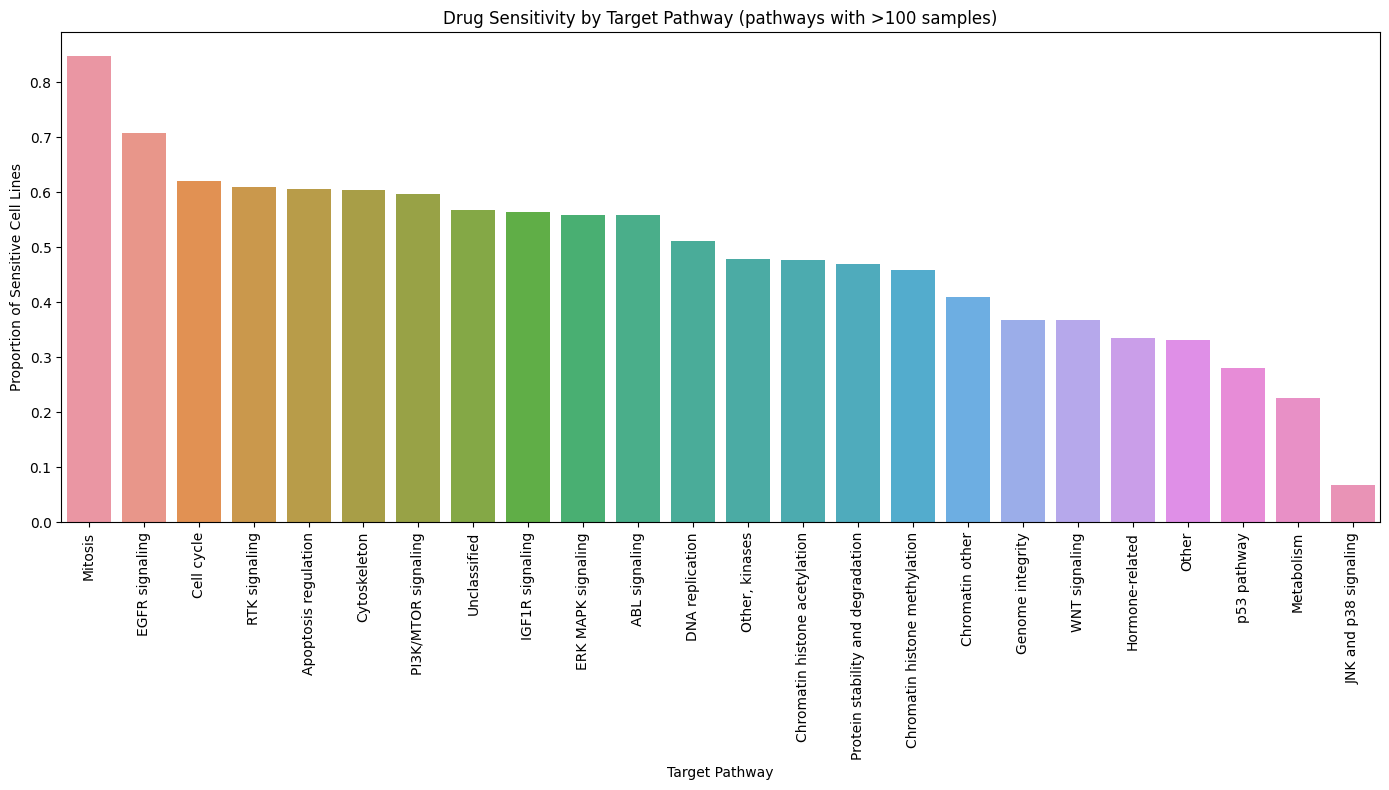

In [29]:
# Perform analysis of sensitivity by drug target pathway
plt.figure(figsize=(14, 8))
pathway_sensitivity = Data.groupby('TARGET_PATHWAY')['Drug_Sensitivity'].agg(['mean', 'count'])
pathway_sensitivity = pathway_sensitivity.sort_values('mean', ascending=False)
pathway_sensitivity = pathway_sensitivity[pathway_sensitivity['count'] > 100]  # Filter for pathways with sufficient data

# Plot pathway sensitivity
sns.barplot(x=pathway_sensitivity.index, y=pathway_sensitivity['mean'])
plt.title('Drug Sensitivity by Target Pathway (pathways with >100 samples)')
plt.xlabel('Target Pathway')
plt.ylabel('Proportion of Sensitive Cell Lines')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/kaggle/working/pathway_sensitivity.png')
plt.show()

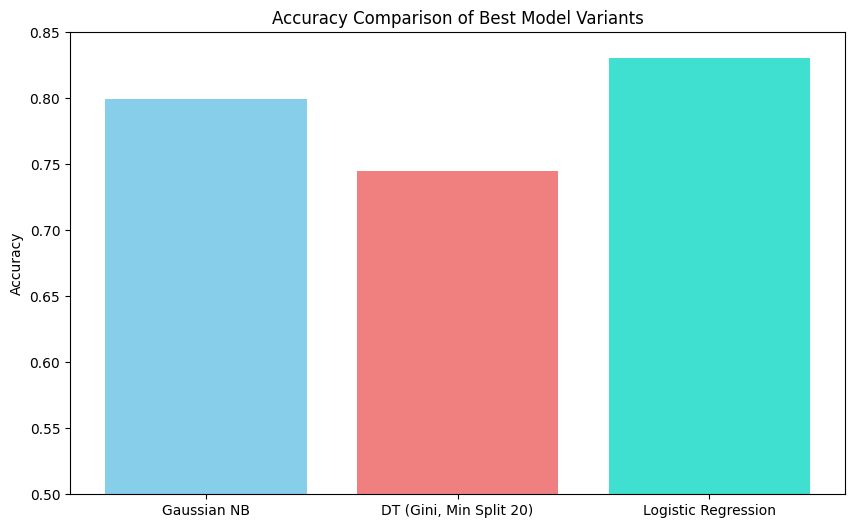

In [39]:
models = ['Gaussian NB', 'DT (Gini, Min Split 20)', 'Logistic Regression']
accuracies = [0.7993, 0.7448, 0.8303]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'turquoise'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Best Model Variants')
plt.ylim(0.5, 0.85)
plt.savefig('/kaggle/working/Final_comparison_3_algos.png')
plt.show()